# Physics-Informed Neural Networks

We will try to use PINNs to predict the evolution of the temperature of an object in a room 

# Import

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat
import seaborn as sns
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)


# Dataset Creation

First, we will generate a dataset using Newton's law of cooling:

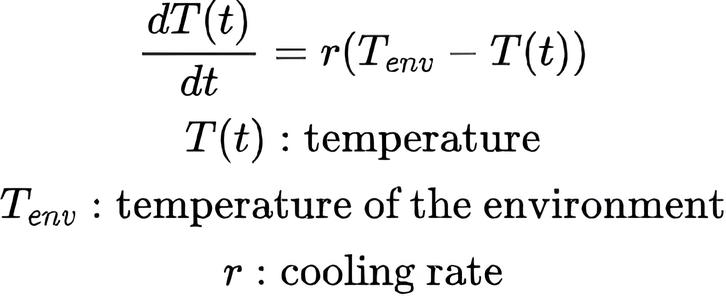

Text(0.5, 0, 'Time (s)')

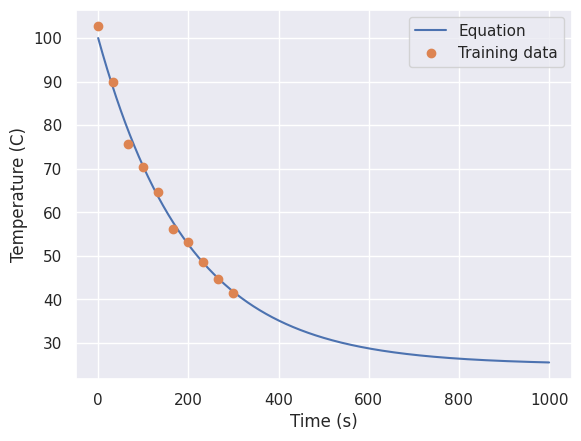

In [2]:
def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

Tenv = 25 #Temperature of the room
T0 = 100  #Temperature of my object
R = 0.005 #Coefficient of heat transfer

#Make a test set (ground truth)
times = np.linspace(0, 1000, 1000)
temps=cooling_law(times, Tenv, T0, R)

# Make training data
ti = np.linspace(0, 300, 10)
Te = cooling_law(ti, Tenv, T0, R) +  2 * np.random.randn(10) #we add noise because temperature measurements are never perfect


plt.plot(times, temps)
plt.plot(ti, Te, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


# Vanilla Networks

Let's try to create a dense neural network to predict the temperature knowing the time

In [3]:
#Convert a numpy array into a torch tensor
def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

#Define our Dense neural networ
class Net(nn.Module):
    def __init__(self,input_dim,output_dim,n_units=100,epochs=1000,loss=nn.MSELoss(),lr=1e-3,loss2=None,loss2_weight=0,):

        super().__init__() #Initialize the object using nn.Module initialization
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)
    # The 'forward' method defines how the input data passes through the model.
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    # The 'fit' method is used to train the model on the given dataset.
    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    # The 'predict' method is used to generate predictions from the model for new data.
    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


Train our Dense neural network:

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2509.85
Epoch 4000/20000, loss: 2140.92
Epoch 6000/20000, loss: 724.36
Epoch 8000/20000, loss: 87.45
Epoch 10000/20000, loss: 2.21
Epoch 12000/20000, loss: 0.58
Epoch 14000/20000, loss: 0.43
Epoch 16000/20000, loss: 0.32
Epoch 18000/20000, loss: 0.30


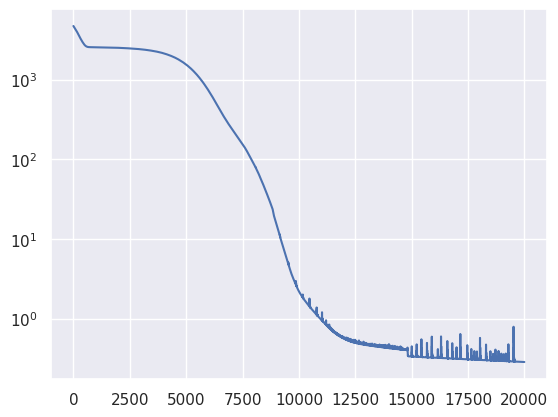

In [4]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(ti, Te)

plt.plot(losses)
plt.yscale('log')

Test our network on the test set:

Text(0.5, 0, 'Time (s)')

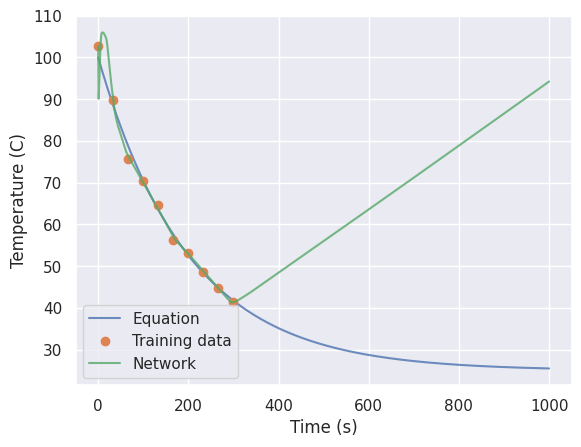

In [5]:
preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(ti, Te, 'o')
plt.plot(times, preds, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


The network become completely inaccurate as we leave the realm of the training data, which is to be expected (they have no information where there is no data).

# PINN

To solve this issue let's try adding a physical loss to the model, using the following equivalence:
$\frac{dT(t)}{dt} = r(T_{\text{env}} - T(t)) <=>  r(T_{\text{env}} - T(t))-\frac{dT(t)}{dt} =0$

In [6]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT=torch.autograd.grad(temps, ts, grad_outputs=torch.ones_like(temps), create_graph=True)[0]
    pde = R*(Tenv - temps) - dT
    return torch.mean(pde**2)

Train our PINNs:

In [ ]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(ti, Te)
plt.plot(losses)
plt.yscale('log')

Epoch 0/30000, loss: 4622.81
Epoch 3000/30000, loss: 2365.68
Epoch 6000/30000, loss: 233.82
Epoch 9000/30000, loss: 1.86


Test our network on the test set:

In [ ]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(ti, Te, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINNs'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

The inclusion of the physics loss enables the neural network to generalize more effectively beyond the training data distribution.

# Parameter discovery

Consider the case where the heat transfer coefficient is unknown. We will demonstrate how PINNs can assist in discovering its value through data and the underlying physics.

Create new physics loss that use a trainable parameter r

In [ ]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT=torch.autograd.grad(temps, ts, grad_outputs=torch.ones_like(temps), create_graph=True)[0]
    pde = model.r * (Tenv - temps) - dT #r is now a parameter of the model

    return torch.mean(pde**2)

Create a network class with a trainable parameter r

In [ ]:
class NetDiscovery(Net):
    def __init__(self,input_dim,output_dim,n_units=100,epochs=1000,loss=nn.MSELoss(),lr=0.001,loss2=None,loss2_weight=0.1,):
        super().__init__(input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight) #Initialize the object using Net initialization
        self.r = nn.Parameter(data=torch.tensor([0.])) #Add a trainable parameter in the neural network

Train our PINNs

In [ ]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(ti, Te)
plt.plot(losses)
plt.yscale('log')

Test our network on the test set

In [ ]:
preds = netdisc.predict(times)
print("Estimated heat transfer coefficient: ",netdisc.r.detach().numpy()[0])

plt.plot(times, temps, alpha=0.8)
plt.plot(ti, Te, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINNs'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

We find a value of the heat transfer coefficient very close to the real value.

# Conclusion

* PINNs offer an efficient way to simulate differential equations, especially when conventional solvers are too slow or resource-intensive
* PINNs are capable of inferring parameter values within differential equations